In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

In [2]:
# Loading the dataset generated by the team
df = pd.read_csv('./data/credit_risk_dataset.csv')

# Drop the raw text column (the model can't read sentences, only numbers/categories)
# Note: Your team already extracted 'sentiment' and 'risk_category' using GenAI, so we use those instead.
df_clean = df.drop(columns=['customer_financial_statement'])

In [3]:
# List of columns that are text (Categorical)
categorical_cols = [
    'employment_type', 'education_level', 'marital_status', 
    'region', 'sentiment', 'financial_stress_level', 'risk_category'
]

# Encode them (Turn "High Risk" into 2, "Low Risk" into 0, etc.)
le = LabelEncoder()
mapping_dict = {} # To keep track of what number means what

for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])
    mapping_dict[col] = dict(zip(le.classes_, le.transform(le.classes_)))

print("Data encoded successfully.")

# Define X (Features) and y (Target)
X = df_clean.drop('default_risk', axis=1)
y = df_clean['default_risk']

# Split: 80% Training, 20% Testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Features Shape: {X_train.shape}")
print(f"Testing Features Shape: {X_test.shape}")

Data encoded successfully.
Training Features Shape: (1200, 15)
Testing Features Shape: (300, 15)


In [4]:
# Initialize the model
# n_estimators=100 means we create 100 decision trees
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

print("Random Forest Model Trained Successfully!")

Random Forest Model Trained Successfully!


Accuracy: 0.9733333333333334
ROC-AUC Score: 0.996589653681733

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       191
           1       0.98      0.94      0.96       109

    accuracy                           0.97       300
   macro avg       0.98      0.97      0.97       300
weighted avg       0.97      0.97      0.97       300



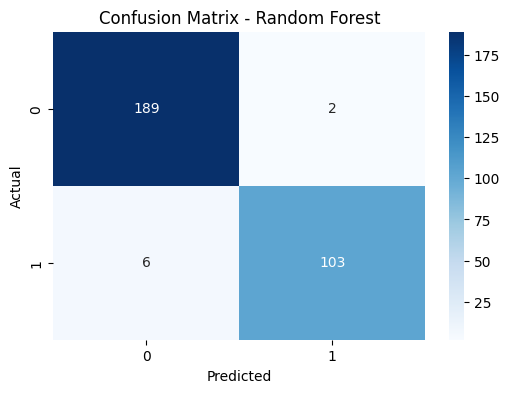

In [5]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] # Probability for ROC-AUC

# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

C:\Users\Iman Haikal\AppData\Local\Temp\ipykernel_26864\692992306.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


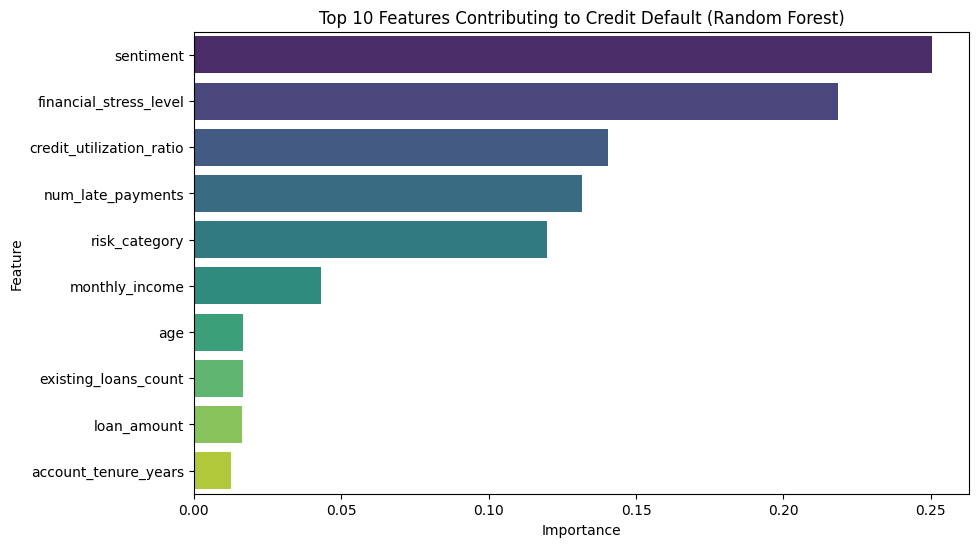

In [6]:
# Extract importance
importances = rf_model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort and Plot
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Features Contributing to Credit Default (Random Forest)')
plt.show()

In [8]:
import os
import google.generativeai as genai
from dotenv import load_dotenv

# 1. Setup Gemini (Reusing team's setup)
load_dotenv()
api_key = os.getenv("GEMINI_API_KEY")

if not api_key:
    print("⚠️ Warning: GEMINI_API_KEY not found in .env file. AI interpretation skipped.")
else:
    genai.configure(api_key=api_key)
    model = genai.GenerativeModel('gemini-3-flash-preview')

    # 2. Prepare the data for the AI
    # We convert our metrics and feature importance into a text string
    top_features = feature_importance_df.head(5).to_string(index=False)
    accuracy_val = accuracy_score(y_test, y_pred)
    roc_val = roc_auc_score(y_test, y_prob)
    
    analysis_prompt = f"""
    You are a Senior Data Scientist in a bank.
    I have trained a Random Forest model to predict credit default risk.
    
    Here are the performance metrics:
    - Accuracy: {accuracy_val:.2f}
    - ROC-AUC Score: {roc_val:.2f}
    
    Here are the top 5 most important features driving the model:
    {top_features}
    
    Task:
    1. Summarize the model's performance (is it good for a bank?).
    2. Interpret the top features. Explain WHY these specific features might be predicting default risk based on financial logic.
    3. Provide a brief business recommendation on how to use this model.
    """

    print("🤖 Asking Gemini to interpret the results...\n")
    
    try:
        response = model.generate_content(analysis_prompt)
        print("--- AI Analysis Report ---")
        print(response.text)
        
        # Optional: Save this analysis to a text file for the final report
        with open("model_interpretation_RF.txt", "w") as f:
            f.write(response.text)
            
    except Exception as e:
        print(f"Error communicating with Gemini: {e}")

🤖 Asking Gemini to interpret the results...

--- AI Analysis Report ---
Hello. As a Senior Data Scientist here at the bank, I’ve reviewed your Random Forest model results. While the numbers look impressive on the surface, we need to look closer at what they mean for a regulated financial institution.

Here is my assessment of the model, the feature logic, and how we should proceed.

---

### 1. Performance Summary: Is it good for a bank?

To be blunt: **An ROC-AUC of 1.00 is a significant "red flag" in credit risk modeling.**

*   **The "Too Good to be True" Problem:** In real-world banking, predicting default is never perfect because human behavior is stochastic. A perfect AUC of 1.00 usually indicates **Data Leakage**. This means the model is likely "cheating" by using a feature that already contains the answer (e.g., a variable that is only updated *after* a customer defaults).
*   **Accuracy vs. Imbalance:** An accuracy of 0.97 is high, but if 97% of our customers don't default (wh